#!/usr/bin/env python
# coding: utf-8
# # %pip install tensorflow matplotlib seaborn scikit-learn
# C:\Users\happy\Documents\ironhack\Week7\set2\Project2-G2>pylint project2group2cnn.py --disable=E1101,E0611,E0401

# -------------------------------------------------------------------
# Your code has been rated at 10.00/10 (previous run: 6.92/10, +3.08)
"""
Train and evaluate a CNN on CIFAR-10 using transfer learning with MobileNetV2.
Includes preprocessing, model training, evaluation, fine-tuning, and saving.
"""

In [1]:
# Import necessary libraries
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
#Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]



In [ ]:
# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

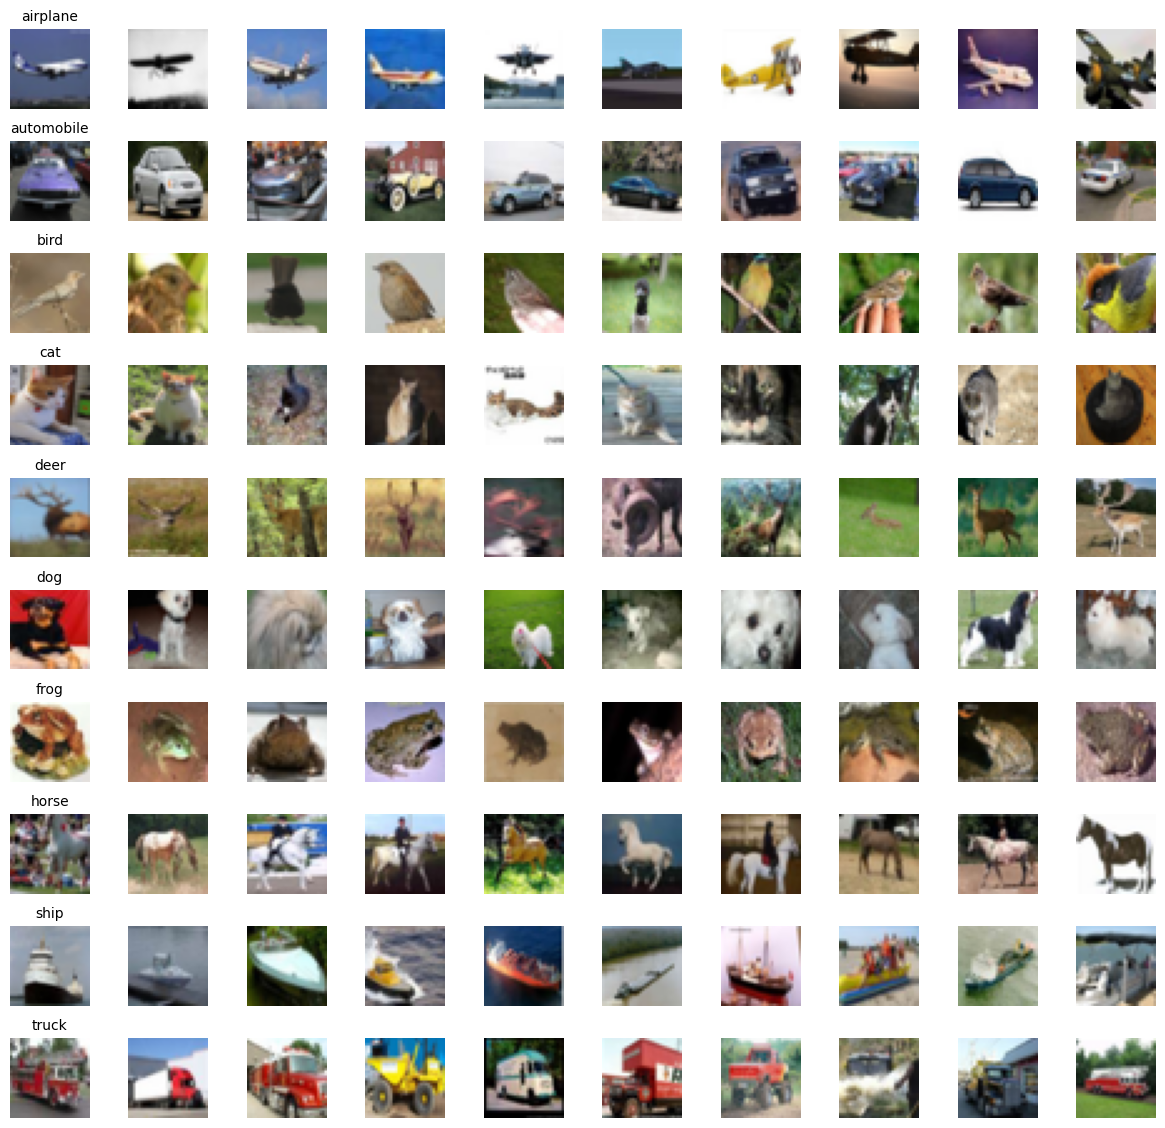

In [ ]:
# Visualize sample images
#Plot data
y_labels = np.argmax(y_train_cat, axis=1)

# Plot 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# For each class (0 to 9)
for class_id in range(10):
    # Get all indices of that class
    idxs = np.where(y_labels == class_id)[0]
    # Choose 10 random samples from that class
    selected_idxs = np.random.choice(idxs, 10, replace=False)

    for i in range(10):
        ax = axes[class_id, i]
        ax.imshow(x_train[selected_idxs[i]])
        ax.axis('off')
        if i == 0:
            ax.set_title(class_names[class_id], fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [6]:
#Normalize CIFAR-10 data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [7]:
#Improve generalization through data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [8]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
y_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [10]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Train the model
# Define callbacks
callbacks = [
    #Stops training if the validation loss doesn’t improve after a set number of epochs.Prevent overfitting.
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
      ),
    #Reduces the learning rate when validation loss stalls.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, patience=3,
        min_lr=1e-5
      ),
    #Save the best model to disk during training.
    ModelCheckpoint('cnn_optimized_baseline.keras',
        monitor='val_loss',
        save_best_only=True
      )
]

model.fit(datagen.flow(x_train, y_train_cat, batch_size=64),
          validation_data=(x_test, y_test_cat),
          epochs=50,
          callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3465 - loss: 2.0205 - val_accuracy: 0.4979 - val_loss: 1.4125 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.5347 - loss: 1.2962 - val_accuracy: 0.6373 - val_loss: 1.0563 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.6065 - loss: 1.1126 - val_accuracy: 0.6217 - val_loss: 1.1834 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.6454 - loss: 1.0162 - val_accuracy: 0.6175 - val_loss: 1.1467 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6616 - loss: 0.9696 - val_accuracy: 0.6939 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6844 - loss: 0.9005 - val_accuracy: 0.7137 - val_loss: 0.8279 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6976 - loss: 0.8797

In [12]:
#Verify saving
DRIVE_PATH = '/content/'
for item in os.listdir(DRIVE_PATH):
    print(item)

.config
drive
cnn_optimized_baseline.keras
sample_data
